# IBM ADVANCED DATA SCIENCE CAPSTONE PROJECT 


## WATER QUALITY PREDICTION


### Uploading the data
#### Firstly, we upload the data in the spark frame.

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200509190433-0000
KERNEL_ID = 769eaaef-e12b-47fd-a1d8-c4673cb320b2
+------------+--------------------+--------------+----+---+---+------------+----+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|         STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+--------------+----+---+---+------------+----+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|   MAHARASHTRA|29.2|6.4|8.1|         735| 3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|   MAHARASHTRA|24.5|  6|  8|         270| 3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|   MAHARASHTRA|25.8|5.5|7.8|         355| 4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|   MAHARASHTRA|24

In [2]:
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [3]:
import numpy as np
import pandas as pd

In [4]:
from pyspark.sql.types import FloatType

#### As we observed obove that all the columns have string data types, but for the calculation of water quality index we need to convert them in float data type. So we will convert the required columns in the float data type.

In [5]:
df = df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df = df.withColumn("pH",df["pH"].cast(FloatType()))
df = df.withColumn("DO",df["DO"].cast(FloatType()))
df = df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df = df.withColumn("BOD",df["BOD"].cast(FloatType()))
df = df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df = df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

#### Now as column TOTAL_COLIFORM is not required so we will drop this column. 

In [6]:
df=df.drop('TOTAL_COLIFORM')

#### Now we want to remove all the rows which contain any null value in it. So for applying a SQL query we first have to register it has a virtual temporary table and then we will issue SQL query. We are doing this because it is important to perform data cleansing steps as it will make our model to work better.

In [7]:
df.createOrReplaceTempView("df_sql")

In [8]:
df_clean = spark.sql('''Select * from df_sql where TEMP is not null and DO is not null 
                        and pH is not null and BOD is not null and CONDUCTIVITY is not null
                        and NITRATE_N_NITRITE_N is not null and FECAL_COLIFORM is not null''')

### Let's visualize our data.

In [9]:
%matplotlib inline

In [10]:
df_clean.createOrReplaceTempView("df_sql")

In [11]:
do = spark.sql("Select DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = spark.sql("Select pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
bod = spark.sql("Select BOD from df_sql")
bod = bod.rdd.map(lambda row : row.BOD).collect()
nn = spark.sql("Select NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

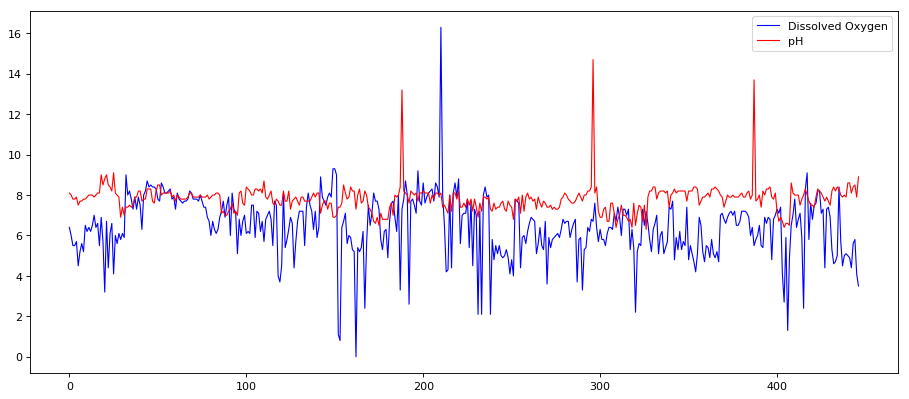

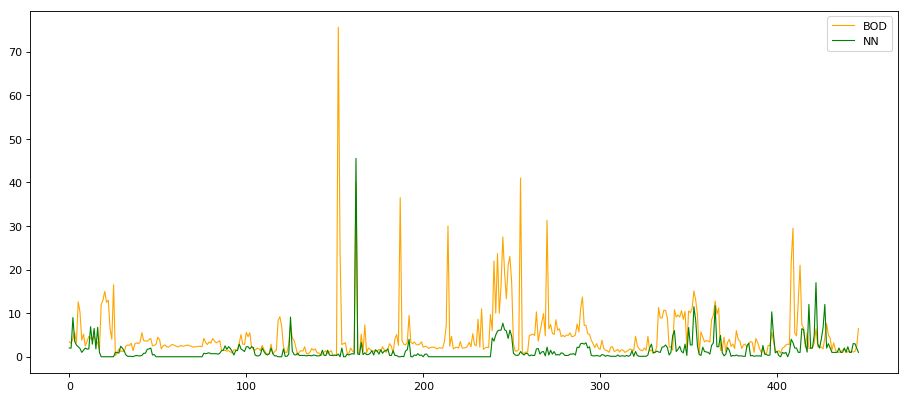

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='blue', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), bod, color='orange', animated=True, linewidth=1, label='BOD')
ax2.plot(range(0,size), nn, color='green', animated=True, linewidth=1, label='NN')
legend=ax.legend()
legend=ax2.legend()

In [13]:
con = spark.sql("Select CONDUCTIVITY from df_sql")
con = con.rdd.map(lambda row : row.CONDUCTIVITY).collect()
fec = spark.sql("Select FECAL_COLIFORM from df_sql")
fec = fec.rdd.map(lambda row : row.FECAL_COLIFORM).collect()

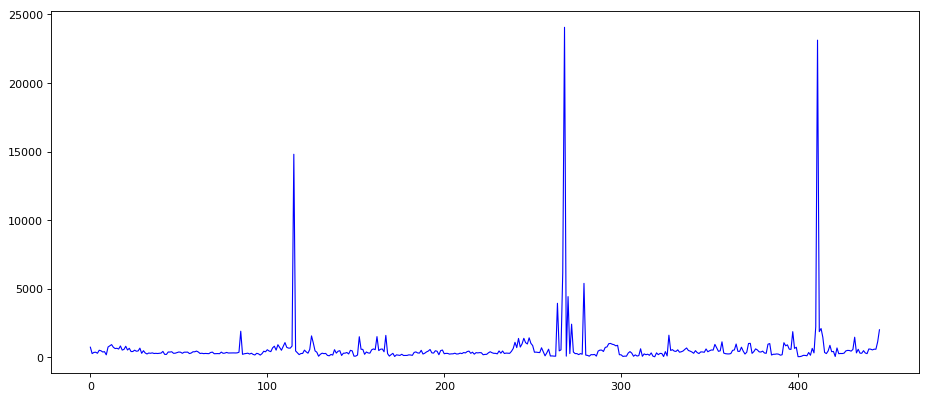

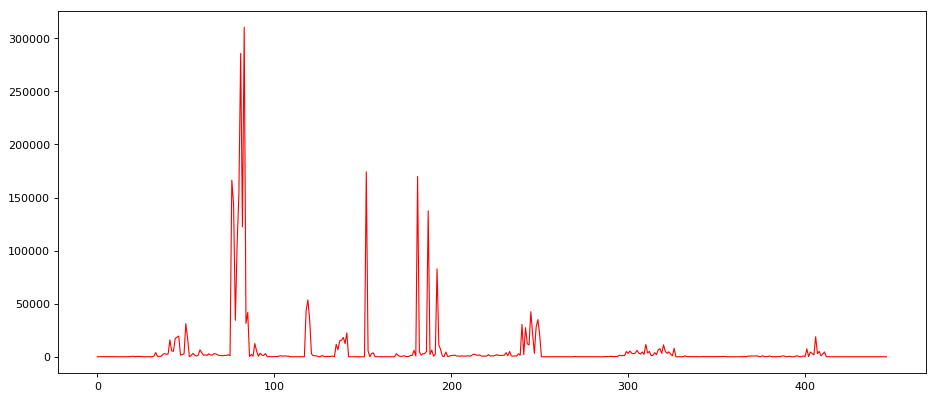

In [14]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), con, color='blue', animated=True, linewidth=1)
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), fec, color='red', animated=True, linewidth=1)

#### Let us convert our data to pandas frame. We are doing this because to train a model we need what we have to predict which is not in data. So we have to calculate water quality index which requires many steps but can be easily done using pandas and in less number of steps. Also we will able to visualize our data in tabular form more effectively.

In [15]:
df=df_clean.toPandas()
df.dtypes

STATION CODE            object
LOCATIONS               object
STATE                   object
TEMP                   float32
DO                     float32
pH                     float32
CONDUCTIVITY           float32
BOD                    float32
NITRATE_N_NITRITE_N    float32
FECAL_COLIFORM         float32
dtype: object

### Initialization

In [16]:
start=0
end=448
station=df.iloc [start:end ,0]
location=df.iloc [start:end ,1]
state=df.iloc [start:end ,2]
do= df.iloc [start:end ,4].astype(np.float64)
value=0
ph = df.iloc[ start:end,5]  
co = df.iloc [start:end ,6].astype(np.float64)
bod = df.iloc [start:end ,7].astype(np.float64)
na= df.iloc [start:end ,8].astype(np.float64)
fc=df.iloc [2:end ,9].astype(np.float64)



In [17]:
df=pd.concat([station,location,state,do,ph,co,bod,na,fc],axis=1)
df. columns = ['station','location','state','do','ph','co','bod','na','fc']

### The Water Quality Index is calculated by aggregating the quality rating with the weight linearly, 
#### WQI = ∑ (qn x Wn)
#### where qn =Quality rating for the nth Water quality parameter, Wn= unit weight for the nth parameters.       
#### Although for calculation qn we have standard formula but it was not possible in this case, so we applied a standard method for calculating quality rating for each parameter.

In [18]:
df['npH']=df.ph.apply(lambda x: (100 if (8.5>=x>=7)  
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8) 
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7) 
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))

In [19]:
df['ndo']=df.do.apply(lambda x:(100 if (x>=6)  
                                 else(80 if  (6>=x>=5.1) 
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3) 
                                              else 0)))))

In [20]:
df['nco']=df.fc.apply(lambda x:(100 if (5>=x>=0)  
                                 else(80 if  (50>=x>=5) 
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500) 
                                              else 0)))))

In [21]:
df['nbdo']=df.bod.apply(lambda x:(100 if (3>=x>=0)  
                                 else(80 if  (6>=x>=3) 
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80) 
                                              else 0)))))

In [22]:
df['nec']=df.co.apply(lambda x:(100 if (75>=x>=0)  
                                 else(80 if  (150>=x>=75) 
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225) 
                                              else 0)))))

In [23]:
df['nna']=df.na.apply(lambda x:(100 if (20>=x>=0)  
                                 else(80 if  (50>=x>=20) 
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100) 
                                              else 0)))))

df.head()
df.dtypes

station      object
location     object
state        object
do          float64
ph          float32
co          float64
bod         float64
na          float64
fc          float64
npH           int64
ndo           int64
nco           int64
nbdo          int64
nec           int64
nna           int64
dtype: object

#### Now we apply the formula of wqi by first multiplying all the quality rating with its weight and then summed all the values.

In [24]:
df['wph']=df.npH * 0.165
df['wdo']=df.ndo * 0.281
df['wbdo']=df.nbdo * 0.234
df['wec']=df.nec* 0.009
df['wna']=df.nna * 0.028
df['wco']=df.nco * 0.281
df['wqi']=df.wph+df.wdo+df.wbdo+df.wec+df.wna+df.wco 
df

,station,location,state,do,ph,co,bod,na,fc,npH,...,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco,wqi
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,6.4,8.1,735.0,3.4,2.00,NaN,100,...,80,0,100,16.5,28.10,18.72,0.00,2.8,0.00,66.12
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,6.0,8.0,270.0,3.1,2.00,NaN,100,...,80,40,100,16.5,28.10,18.72,0.36,2.8,0.00,66.48
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,5.5,7.8,355.0,4.2,9.00,59.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,5.5,7.8,371.0,5.6,3.55,90.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,5.7,7.9,294.0,3.2,2.69,45.0,100,...,80,40,100,16.5,22.48,18.72,0.36,2.8,22.48,83.34
5,2181,GODAVARI RIVER AT KAPILA- GODAVARI CONFLUENCE ...,MAHARASHTRA,4.5,7.5,513.0,12.6,2.30,131.0,100,...,60,0,100,16.5,16.86,14.04,0.00,2.8,16.86,67.06
6,2180,GODAVARI RIVER NEAR TAPOVAN.,MAHARASHTRA,5.2,7.7,475.0,10.3,1.90,122.0,100,...,60,0,100,16.5,22.48,14.04,0.00,2.8,16.86,72.68
7,1096,"GODAVARI AT PANCHAVATI AT RAMKUND,MAHARASHTRA",MAHARASHTRA,5.6,7.7,385.0,3.8,1.00,110.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
8,1211,"GODAVARI AT NASIK D/S, MAHARASHTRA",MAHARASHTRA,5.2,7.8,410.0,5.2,1.50,77.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
9,1095,"GODAVARI AT U/S OF GANGAPUR DAM,NASIK,MAHARASHTRA",MAHARASHTRA,6.5,7.8,178.0,2.5,1.99,22.0,100,...,100,60,100,16.5,28.10,23.40,0.54,2.8,22.48,93.82


#### Then we classify the water on the basis of their water quality index.

In [25]:
df['quality']=df.wqi.apply(lambda x:('Excellent' if (25>=x>=0)  
                                 else('Good' if  (50>=x>=26) 
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76) 
                                              else 'Unsuitable')))))

#### Let us again convert the whole data in spark frame for further processes.

In [26]:
spark_df = sqlContext.createDataFrame(df)

In [27]:
spark_df.show()

+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|station|            location|         state|               do|               ph|   co|               bod|                na|   fc|npH|ndo|nco|nbdo|nec|nna|               wph|               wdo|              wbdo|               wec|               wna|               wco|              wqi|  quality|
+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|   1312|GODAVARI AT JAYAK...|   MAHARASHTRA|6.400000095367432|8.100000381469727|735.0|3.40000009536743

#### Let's visualize the water quality index in each state of India.

In [28]:
spark_df.createOrReplaceTempView("df_sql")

In [29]:
State = spark.sql("Select state from df_sql")
State = State.rdd.map(lambda row : row.state).collect()

In [30]:
Wqi = spark.sql("Select wqi from df_sql")
Wqi = Wqi.rdd.map(lambda row : row.wqi).collect()

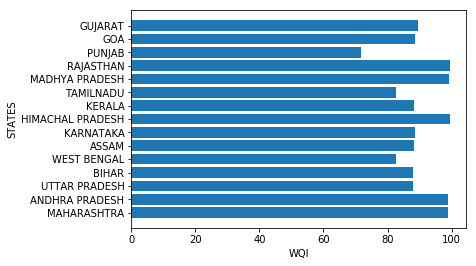

In [31]:
plt.barh(State,Wqi)

plt.xlabel("WQI")
plt.ylabel("STATES")


plt.show()

## Model Creation
#### Now we apply machine learning and deep learning algorithms to predict the data.

## Non Deep Learning Based Linear Regresion Model

#### In this, first data is converted which are required to predict WQI into vector form by using VectorAssembler. Then we normalize our data by using Normalizer.

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

#### Then import LinearRegression from pyspark.ml.regression and applied it to our normalized data. Afterthat, import Pipeline from pyspark.ml and include all those steps in the pipeline that have been done.

In [33]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features_norm",labelCol="wqi",maxIter=10,regParam=0.3,elasticNetParam=0.2)

In [34]:
from pyspark.ml import Pipeline

In [35]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,lr])

#### Before training, our data is randomly split in two parts so as to avoid overfitting and then training is done.

In [36]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

In [37]:
model = pipeline.fit(train_data)

In [38]:
predictions = model.transform(train_data)

In [39]:
predictions.select("wqi","prediction").show()

+-----------------+-----------------+
|              wqi|       prediction|
+-----------------+-----------------+
|82.03999999999999| 82.1425353320257|
|             82.4|81.82425098626744|
|            66.12|67.52084408276048|
|            66.12|67.52084408276048|
|            66.12|67.52084408276048|
|            66.12|67.52084408276048|
|            66.12|67.52084408276048|
|             82.4|81.82425098626744|
|             82.4|81.82425098626744|
|77.36000000000001|77.92012060472051|
|77.36000000000001|77.92012060472051|
|            77.72|77.68601072484154|
|77.36000000000001|77.92012060472051|
|            66.12|67.52084408276048|
|82.03999999999999| 82.1425353320257|
|82.03999999999999| 82.1425353320257|
|            66.12|67.52084408276048|
|82.03999999999999| 82.1425353320257|
|82.03999999999999| 82.1425353320257|
|             82.4|81.82425098626744|
+-----------------+-----------------+
only showing top 20 rows



#### Now we check the performance of our model.

In [40]:
model.stages[2].summary.r2

0.9754588658687834

## Deep Learning Based Linear Regression Model
#### In this first we collect our data in an array form and to reduce number of steps we converted our data in pandas frame. 

In [41]:
df = spark_df.toPandas()

In [42]:
data = df.iloc[:,9:15].values
pred = df.iloc[:,21:22].values

In [43]:
from sklearn.model_selection import train_test_split 
data_train,data_test,pred_train,pred_test = train_test_split(data,pred,test_size=0.20,random_state=1)
pred_train.shape

(357, 1)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


#### Then we initialize model and add layers to it. Afterwards, the model is compiled with optimizer Adam and loss function mean squared error and then training is done.

In [45]:
model2 = Sequential()
model2.add(Dense(350,input_dim=6, activation='relu'))
model2.add(Dense(350,activation='relu'))
model2.add(Dense(350,activation='relu'))
model2.add(Dense(1,activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


In [46]:
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False )
model2.compile(loss='mean_squared_error',optimizer='Adam', metrics=['mse'])

In [47]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 350)               2450      
_________________________________________________________________
dense_2 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_3 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 351       
Total params: 248,501
Trainable params: 248,501
Non-trainable params: 0
_________________________________________________________________


In [48]:
perform = model2.fit(data_train,pred_train,epochs=50,batch_size=32)

Instructions for updating:
Use tf.cast instead.


Epoch 1/50
357/357 [==============================] - 5s 15ms/step - loss: 960.6716 - mean_squared_error: 960.6716
Epoch 2/50
357/357 [==============================] - 4s 12ms/step - loss: 77.3950 - mean_squared_error: 77.3950
Epoch 3/50
357/357 [==============================] - 5s 13ms/step - loss: 35.0193 - mean_squared_error: 35.0193
Epoch 4/50
357/357 [==============================] - 5s 14ms/step - loss: 7.7247 - mean_squared_error: 7.7247
Epoch 5/50
357/357 [==============================] - 5s 13ms/step - loss: 2.1497 - mean_squared_error: 2.1497
Epoch 6/50
357/357 [==============================] - 5s 14ms/step - loss: 0.8651 - mean_squared_error: 0.8651
Epoch 7/50
357/357 [==============================] - 5s 15ms/step - loss: 0.4911 - mean_squared_error: 0.4911
Epoch 8/50
357/357 [==============================] - 5s 14ms/step - loss: 0.3037 - mean_squared_error: 0.3037
Epoch 9/50
357/357 [==============================] - 5s 13ms/step - loss: 0.2036 - mean_squared_error: 

In [49]:
prediction = model2.predict(data_train)

#### Now we check performance of our model

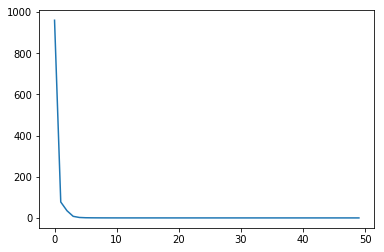

In [50]:
plt.plot(perform.history['mean_squared_error'])

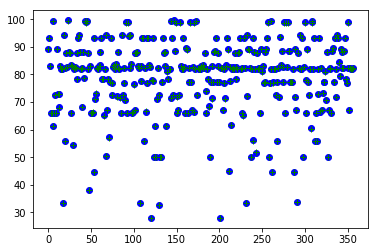

In [51]:
plt.plot(pred_train,'bo',prediction,'g+')

## Water Quality Prediction
#### After predicting water quality index, now we classify water on the basis of its WQI and predict its quality.

In [52]:
spark_df = sqlContext.createDataFrame(df)

## Logistic Regression Model
#### Here we are creating a logistic regression model because we don't have to predict a continuous value. 

In [53]:
from pyspark.ml.feature import StringIndexer

#### As our quality column contains values in string format so first we indexed them using StringIndexer. Then data is converted which are required to predict water quality into vector form by using VectorAssembler. Then we normalize our data by using Normalizer.

In [54]:
indexer = StringIndexer(inputCol="quality",outputCol="label")
vectorAssembler2 = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco","wqi"], outputCol="features2")
normalizer2 = Normalizer(inputCol="features2",outputCol="features_norm2")

#### Then import LogisticRegression from pyspark.ml.classification and applied it to our normalized data. Afterthat, import Pipeline from pyspark.ml and include all those steps in the pipeline that have been done.

In [55]:
from pyspark.ml.classification import LogisticRegression

In [56]:
lor = LogisticRegression(featuresCol="features_norm2",labelCol="label",maxIter=10)

In [57]:
pipeline2 = Pipeline(stages=[indexer,vectorAssembler2,normalizer2,lor])

In [58]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

In [59]:
model3 = pipeline2.fit(train_data)

In [60]:
predictions2 = model3.transform(train_data)

#### Now let us check our predictions.

In [61]:
predictions2.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



#### Now we check performance of our model.

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
eval.evaluate(predictions2)

0.94579945799458

#### As the quality column is in string format so we convert our predicted data which are in numbers to their real string values and compared with the actual data.

In [63]:
names = ["Very Poor","Poor","Good","Unsuitable","Excellent"]

In [64]:
predictions2.createOrReplaceTempView("predictions2_sql")

In [65]:
pred = spark.sql("Select prediction from predictions2_sql")
pred = pred.rdd.map(lambda row : int(row.prediction)).collect()
qua = spark.sql("Select quality from predictions2_sql")
qua = qua.rdd.map(lambda row : row.quality).collect()

In [66]:
for x in range(100):
    print("Predicted:", names[pred[x]], "Actual:", qua[x])

Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poo